In [2]:
import zipfile
import os

Zip_file = '/content/metadata.zip'
Extract_folder = 'unzipped'

# Corrected line with the closing parenthesis
os.makedirs(Extract_folder, exist_ok=True)

with zipfile.ZipFile(Zip_file, 'r') as zip_ref:
    zip_ref.extractall(Extract_folder)

print(f"Files extracted to {Extract_folder}")


Files extracted to unzipped


In [3]:
import librosa
import numpy as np

# List of audio file paths
Audio_path = [
    "/content/unzipped/wav/LJ001-0001.wav", "/content/unzipped/wav/LJ001-0002.wav", "/content/unzipped/wav/LJ001-0003.wav",
    "/content/unzipped/wav/LJ001-0004.wav", "/content/unzipped/wav/LJ001-0005.wav", "/content/unzipped/wav/LJ001-0006.wav",
    "/content/unzipped/wav/LJ001-0007.wav", "/content/unzipped/wav/LJ001-0008.wav", "/content/unzipped/wav/LJ001-0009.wav",
    "/content/unzipped/wav/LJ001-0010.wav", "/content/unzipped/wav/LJ001-0011.wav", "/content/unzipped/wav/LJ001-0012.wav",
    "/content/unzipped/wav/LJ001-0013.wav", "/content/unzipped/wav/LJ001-0014.wav", "/content/unzipped/wav/LJ001-0015.wav",
    "/content/unzipped/wav/LJ001-0016.wav", "/content/unzipped/wav/LJ001-0017.wav", "/content/unzipped/wav/LJ001-0018.wav",
    "/content/unzipped/wav/LJ001-0019.wav", "/content/unzipped/wav/LJ001-0020.wav"
]

# Function for noise reduction
def reduce_noise(y, noise_reduction_factor=0.1):
    noise = np.random.randn(len(y))
    augmented_data = y + noise_reduction_factor * noise
    return augmented_data

# Process
for audio_path in Audio_path:
    y, sr = librosa.load(audio_path, sr=None)

    # Apply noise
    y_clean = reduce_noise(y)

    # Normalize the audio
    y_normalized = librosa.util.normalize(y_clean)

    # Save
    print(f"Processed {audio_path}")



Processed /content/unzipped/wav/LJ001-0001.wav
Processed /content/unzipped/wav/LJ001-0002.wav
Processed /content/unzipped/wav/LJ001-0003.wav
Processed /content/unzipped/wav/LJ001-0004.wav
Processed /content/unzipped/wav/LJ001-0005.wav
Processed /content/unzipped/wav/LJ001-0006.wav
Processed /content/unzipped/wav/LJ001-0007.wav
Processed /content/unzipped/wav/LJ001-0008.wav
Processed /content/unzipped/wav/LJ001-0009.wav
Processed /content/unzipped/wav/LJ001-0010.wav
Processed /content/unzipped/wav/LJ001-0011.wav
Processed /content/unzipped/wav/LJ001-0012.wav
Processed /content/unzipped/wav/LJ001-0013.wav
Processed /content/unzipped/wav/LJ001-0014.wav
Processed /content/unzipped/wav/LJ001-0015.wav
Processed /content/unzipped/wav/LJ001-0016.wav
Processed /content/unzipped/wav/LJ001-0017.wav
Processed /content/unzipped/wav/LJ001-0018.wav
Processed /content/unzipped/wav/LJ001-0019.wav
Processed /content/unzipped/wav/LJ001-0020.wav


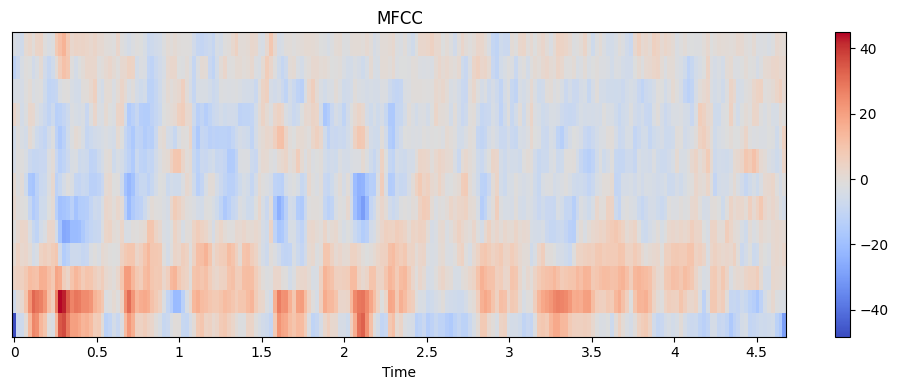

In [4]:
# Extracting MFCCs
MFCCs = librosa.feature.mfcc(y=y_normalized, sr=sr, n_mfcc=13)

# Visualizing MFCCs
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
librosa.display.specshow(MFCCs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()


In [5]:
import pandas as pd
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical

def load_audio_file(file_path):
    y, sr = librosa.load(file_path, sr=None)
    return librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T

def load_labels(file_path):
    try:
        df = pd.read_csv(file_path, delimiter=',', quotechar='"', header=None, on_bad_lines='warn', engine='python')
        return df.values.flatten()
    except (pd.errors.ParserError, FileNotFoundError) as e:
        print(f"Error: {e}")
        raise

audio_paths = [
    f"/content/unzipped/wav/LJ001-00{str(i).zfill(2)}.wav" for i in range(1, 21)
]

max_timesteps = 416

def process_audio_paths(audio_paths):
    return np.array([
        tf.keras.preprocessing.sequence.pad_sequences([load_audio_file(path)], maxlen=max_timesteps, padding='post', dtype='float32')[0]
        for path in audio_paths
    ])

X_train = process_audio_paths(audio_paths[:15])
X_val = process_audio_paths(audio_paths[15:])

print("X_train shape before reshaping:", X_train.shape)
print("X_val shape before reshaping:", X_val.shape)

y_train = load_labels("/content/unzipped/metadata.csv")[:15]
y_val = load_labels("/content/unzipped/metadata.csv")[15:20]

print("y_train content:", y_train)
print("y_val content:", y_val)

if y_train is None or y_val is None:
    raise ValueError("Labels are None. Check the labels file.")

y_train = pd.to_numeric(y_train, errors='coerce').astype(int)
y_val = pd.to_numeric(y_val, errors='coerce').astype(int)

unique_labels = np.unique(np.concatenate([y_train, y_val]))
num_classes = len(unique_labels)

print("Unique labels:", unique_labels)
print("Number of classes:", num_classes)

y_train = np.clip(y_train, 0, num_classes - 1)
y_val = np.clip(y_val, 0, num_classes - 1)

y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

model = Sequential([
    LSTM(128, input_shape=(max_timesteps, X_train.shape[2]), return_sequences=True),
    LSTM(64),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))


X_train shape before reshaping: (15, 416, 13)
X_val shape before reshaping: (5, 416, 13)
y_train content: ['LJ001-0001|Printing' 'LJ001-0002|Printing' 'LJ001-0003|Printing'
 'LJ001-0004|Printing' 'LJ001-0005|Printing' 'LJ001-0006|Printing'
 'LJ001-0007|Printing' 'LJ001-0008|Printing' 'LJ001-0009|Printing'
 'LJ001-0010|Printing' 'LJ001-0011|Printing' 'LJ001-0012|Printing'
 'LJ001-0013|Printing' 'LJ001-0014|Printing' 'LJ001-0015|Printing']
y_val content: ['LJ001-0016|Printing' 'LJ001-0017|Printing' 'LJ001-0018|Printing'
 'LJ001-0019|Printing' 'LJ001-0020|Printing']
Unique labels: [-9223372036854775808]
Number of classes: 1
X_train shape: (15, 416, 13)
y_train shape: (15, 1)
X_val shape: (5, 416, 13)
y_val shape: (5, 1)


<ipython-input-5-6e94bfa00279>:48: RuntimeWarning: invalid value encountered in cast
  y_train = pd.to_numeric(y_train, errors='coerce').astype(int)
<ipython-input-5-6e94bfa00279>:49: RuntimeWarning: invalid value encountered in cast
  y_val = pd.to_numeric(y_val, errors='coerce').astype(int)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 912ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 1.0000 - loss:

In [6]:
# Evaluating the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {accuracy*100:.2f}%')

# Making predictions
predictions = model.predict(X_val)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Validation Accuracy: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (5, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


In [7]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer
import torchaudio
import torch

# Load the model and tokenizer
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-large-960h")

# Load and preprocess the audio file
def transcribe_audio(audio_path):
    audio_input, _ = torchaudio.load(audio_path)
    audio_input = audio_input.mean(dim=0)  # Convert to mono
    input_values = tokenizer(audio_input.numpy(), return_tensors="pt").input_values
    with torch.no_grad():
        logits = model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = tokenizer.decode(predicted_ids[0])
    return transcription

# Transcribe an audio file
print(transcribe_audio("/content/unzipped/wav/LJ001-0004.wav"))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/wav2vec2-large-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You s

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:720: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(


PRODUCED THE BLOCK BOOKS WHICH WERE THE IMMEDIATE PREDECESSORS OF THE TRUE PRINTED BOOK
